## Setup

In [1]:
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import cv2
import pandas as pd
import numpy as np
import datetime
from PIL import Image
    
from tensorflow import keras
from keras import layers

## 하이퍼 파라미터

In [2]:
# 데이터
# 사용할 데이터셋 이름 : tf.dataset
# dataset_name = "oxford_flowers102"
dataset_name = "cats_vs_dogs"
# 반복할 횟수(1이상으로 잡아야 돌아갑니다.)
dataset_repetitions = 1
# Epoch
num_epochs = 10
# resize시 정할 이미지
image_size = 128

# KID = Kernel Inception Distance, see related section
kid_image_size = 75
kid_diffusion_steps = 5
plot_diffusion_steps = 20

# sampling
min_signal_rate = 0.02
max_signal_rate = 0.95

# architecture
embedding_dims = 32
embedding_max_frequency = 1000.0
widths = [32, 64, 96, 128]
block_depth = 2

# optimization
batch_size = 64
ema = 0.999
learning_rate = 1e-3
weight_decay = 1e-4

## 데이터 파이프라인

In [3]:
# 이미지의 너비와 높이 중 짧은 길이에 맞춰서 center crop하는 함수
def preprocess_image(data):
    # center crop image
    height = tf.shape(data["image"])[0]
    width = tf.shape(data["image"])[1]
    crop_size = tf.minimum(height, width)
    image = tf.image.crop_to_bounding_box(
        data["image"],
        (height - crop_size) // 2,
        (width - crop_size) // 2,
        crop_size,
        crop_size,
    )

    
    # Center crop한 이미지를 Hyper parameter에서 정해준 image_size에 맞게 resize 해줍니다.
    # resize시 이미지 훼손을 최대한 방지하기 위해 antialias를 True로 해줍ㄴ디ㅏ.
    image = tf.image.resize(image, size=[image_size, image_size], antialias=True)
    # 이미지 Array의 값을 float 0~1로 만들어주고 혹시 모를 특이값을 방지하기 위해 clip을 해줍니다.
    return tf.clip_by_value(image / 255.0, 0.0, 1.0)


# 데이터셋을 준비하는 함수
def prepare_dataset(split):
    # KID 측정을 위해서는 shuffle이 되어야 합니다. 데이터 순서가 영향을 주기 때문입니다.
    return (
        # tfds.load를 통해 Hyper parameter에서 정해준 이름의 Dataset을 불러옵니다.
        # 추가로 split 문자열을 통해 train, (validation), test에서 나눠서 가져옵니다.
        # shuffle_files를 통해 파일을 섞어줍니다.
        tfds.load(dataset_name, split=split, shuffle_files=True)
        # map 함수는 해당 함수(ppreprocess_image)를 내부의 값에 모두 적용하는 함수 입니다.
        # num_parallel_calls : 병렬적으로 수행할 요소들의 숫자를 정합니다.
        # tf.data.AUTOTUNE을 적용하면 현재 CPU에 맞게 적용됩니다.
        .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        # 해당 데이터셋의 내부 원소들을 캐시합니다.
        # (캐시 : CPU와 주 메모리 사이에 삽입되는 작고 빠른 메모리 구성요소)
        # 캐시한다 : 여기에 데이터를 올려서 속도 개선
        .cache()
        # 내부 모든 값을 반복합니다.(여러번 concate 한다고 생각하면 됩니다.)
        .repeat(dataset_repetitions)
        # shuffle
        # buffer : 데이터를 전송하기 전에 일시적으로 데이터를 보관하는 메모리의 영역(이동하고자하는 모든 데이터를 담게 된다.)
        .shuffle(10 * batch_size)
        # batch_size에 맞춰 batch를 나눕니다. drop_remainder = True가 된다면 batch 보다 적게 남으면 버립니다.
        .batch(batch_size, drop_remainder=True)
        # 대부분의 Dataset이 prefetch를 통해 끝이 난다.
        # prefetch는 나중의 요소들이 현재 요소들이 계산되느 동안 준비되게 한다.
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

# 데이터셋 불러오기
# train 데이터셋은 train, validation, test의 0~80 부분을 가져옵니다.
train_dataset = prepare_dataset("train[:80%]+validation[:80%]+test[:80%]")
# test 데이터셋은 train, validation, test의 80~100 부분을 가져옵니다.
val_dataset = prepare_dataset("train[80%:]+validation[80%:]+test[80%:]")

print(train_dataset)
print(val_dataset)

<PrefetchDataset shapes: (64, 128, 128, 3), types: tf.float32>
<PrefetchDataset shapes: (64, 128, 128, 3), types: tf.float32>


## KID

* KID : Kernel Inception Distance
* MMD(Maximum Mean Discrepancy)를 feature space에서 진행하는 것을 의미
* 실제 이미지와 가짜 이미지, 가짜 이미지와 실제 이미지 세트간의 similarity를 보는 방법
* 실제 이미지 셋 p, 가짜 이미지셋 q라고 두고
* p에서 2장을 뽑고 두 이미지간의 차이를 구하는 것을 반복해서 이미지들간의 차이가 어떻게 되는지 기댓값을 구합니다.
* q에서도 똑같은 행동을 취합니다.
* 마지막으로 p에서 하나, q에서 하나를 뽑아서 평균적인 차이를 구합니다.

In [4]:
class KID(keras.metrics.Metric):
    def __init__(self, name, **kwargs):
        super().__init__(name=name, **kwargs)

        # KID 배치마다 계산되며 배치간의 값들로 평균을 냅니다.
        self.kid_tracker = keras.metrics.Mean(name="kid_tracker")

        # a pretrained InceptionV3 is used without its classification layer
        # transform the pixel values to the 0-255 range, then use the same
        # preprocessing as during pretraining
        self.encoder = keras.Sequential(
            [
                keras.Input(shape=(image_size, image_size, 3)),
                layers.Rescaling(255.0),
                layers.Resizing(height=kid_image_size, width=kid_image_size),
                layers.Lambda(keras.applications.inception_v3.preprocess_input),
                keras.applications.InceptionV3(
                    include_top=False,
                    input_shape=(kid_image_size, kid_image_size, 3),
                    weights="imagenet",
                ),
                layers.GlobalAveragePooling2D(),
            ],
            name="inception_encoder",
        )

    def polynomial_kernel(self, features_1, features_2):
        feature_dimensions = tf.cast(tf.shape(features_1)[1], dtype=tf.float32)
        return (features_1 @ tf.transpose(features_2) / feature_dimensions + 1.0) ** 3.0

    def update_state(self, real_images, generated_images, sample_weight=None):
        real_features = self.encoder(real_images, training=False)
        generated_features = self.encoder(generated_images, training=False)

        # compute polynomial kernels using the two sets of features
        kernel_real = self.polynomial_kernel(real_features, real_features)
        kernel_generated = self.polynomial_kernel(
            generated_features, generated_features
        )
        kernel_cross = self.polynomial_kernel(real_features, generated_features)

        # estimate the squared maximum mean discrepancy using the average kernel values
        batch_size = tf.shape(real_features)[0]
        batch_size_f = tf.cast(batch_size, dtype=tf.float32)
        mean_kernel_real = tf.reduce_sum(kernel_real * (1.0 - tf.eye(batch_size))) / (
            batch_size_f * (batch_size_f - 1.0)
        )
        mean_kernel_generated = tf.reduce_sum(
            kernel_generated * (1.0 - tf.eye(batch_size))
        ) / (batch_size_f * (batch_size_f - 1.0))
        mean_kernel_cross = tf.reduce_mean(kernel_cross)
        kid = mean_kernel_real + mean_kernel_generated - 2.0 * mean_kernel_cross

        # update the average KID estimate
        self.kid_tracker.update_state(kid)

    def result(self):
        return self.kid_tracker.result()

    def reset_state(self):
        self.kid_tracker.reset_state()


## 네트워크 구조

* U-Net 구조 : Input과 Output이 동일한 형태로
* Downsampling 한 뒤 Upsampling 하는 구조, layer들 간의 skip connectoins은 같은 resolutoin을 가진다.
* 네트워크는 noisy image와 noisy variances 2개의 값을 입력 받습니다.
* Noise variances는 노이즈 제거 과정이 다른 레벨의 노이즈에서 다른 명령(함수)가 필요하기 때문입니다.
* Noise variacnes는 sinusoidal embedding(positional embedding과 비슷한)을 통해 변환됩니다.
* 이 과정은 네트워크가 noise level에 매우 민감하게 만들어주며 이는 좋은 성능과 연결됩니다.
* Lambda layer를 통해 sinusoidal embedding을 구현하였습니다.

### Sinusoidal Embedding

In [5]:
def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    frequencies = tf.exp(
        tf.linspace(
            tf.math.log(embedding_min_frequency),
            tf.math.log(embedding_max_frequency),
            embedding_dims // 2,
        )
    )
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat(
        [tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3
    )
    return embeddings

### Residual Block

* 

In [6]:
def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", activation=keras.activations.swish
        )(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply

### Up Down Block

In [7]:
def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply

### Get Network

In [8]:
def get_network(image_size, widths, block_depth):
    noisy_images = keras.Input(shape=(image_size, image_size, 3))
    noise_variances = keras.Input(shape=(1, 1, 1))

    e = layers.Lambda(sinusoidal_embedding)(noise_variances)
    e = layers.UpSampling2D(size=image_size, interpolation="nearest")(e)

    x = layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
    x = layers.Concatenate()([x, e])

    skips = []
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips])

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)([x, skips])

    x = layers.Conv2D(3, kernel_size=1, kernel_initializer="zeros")(x)

    return keras.Model([noisy_images, noise_variances], x, name="residual_unet")


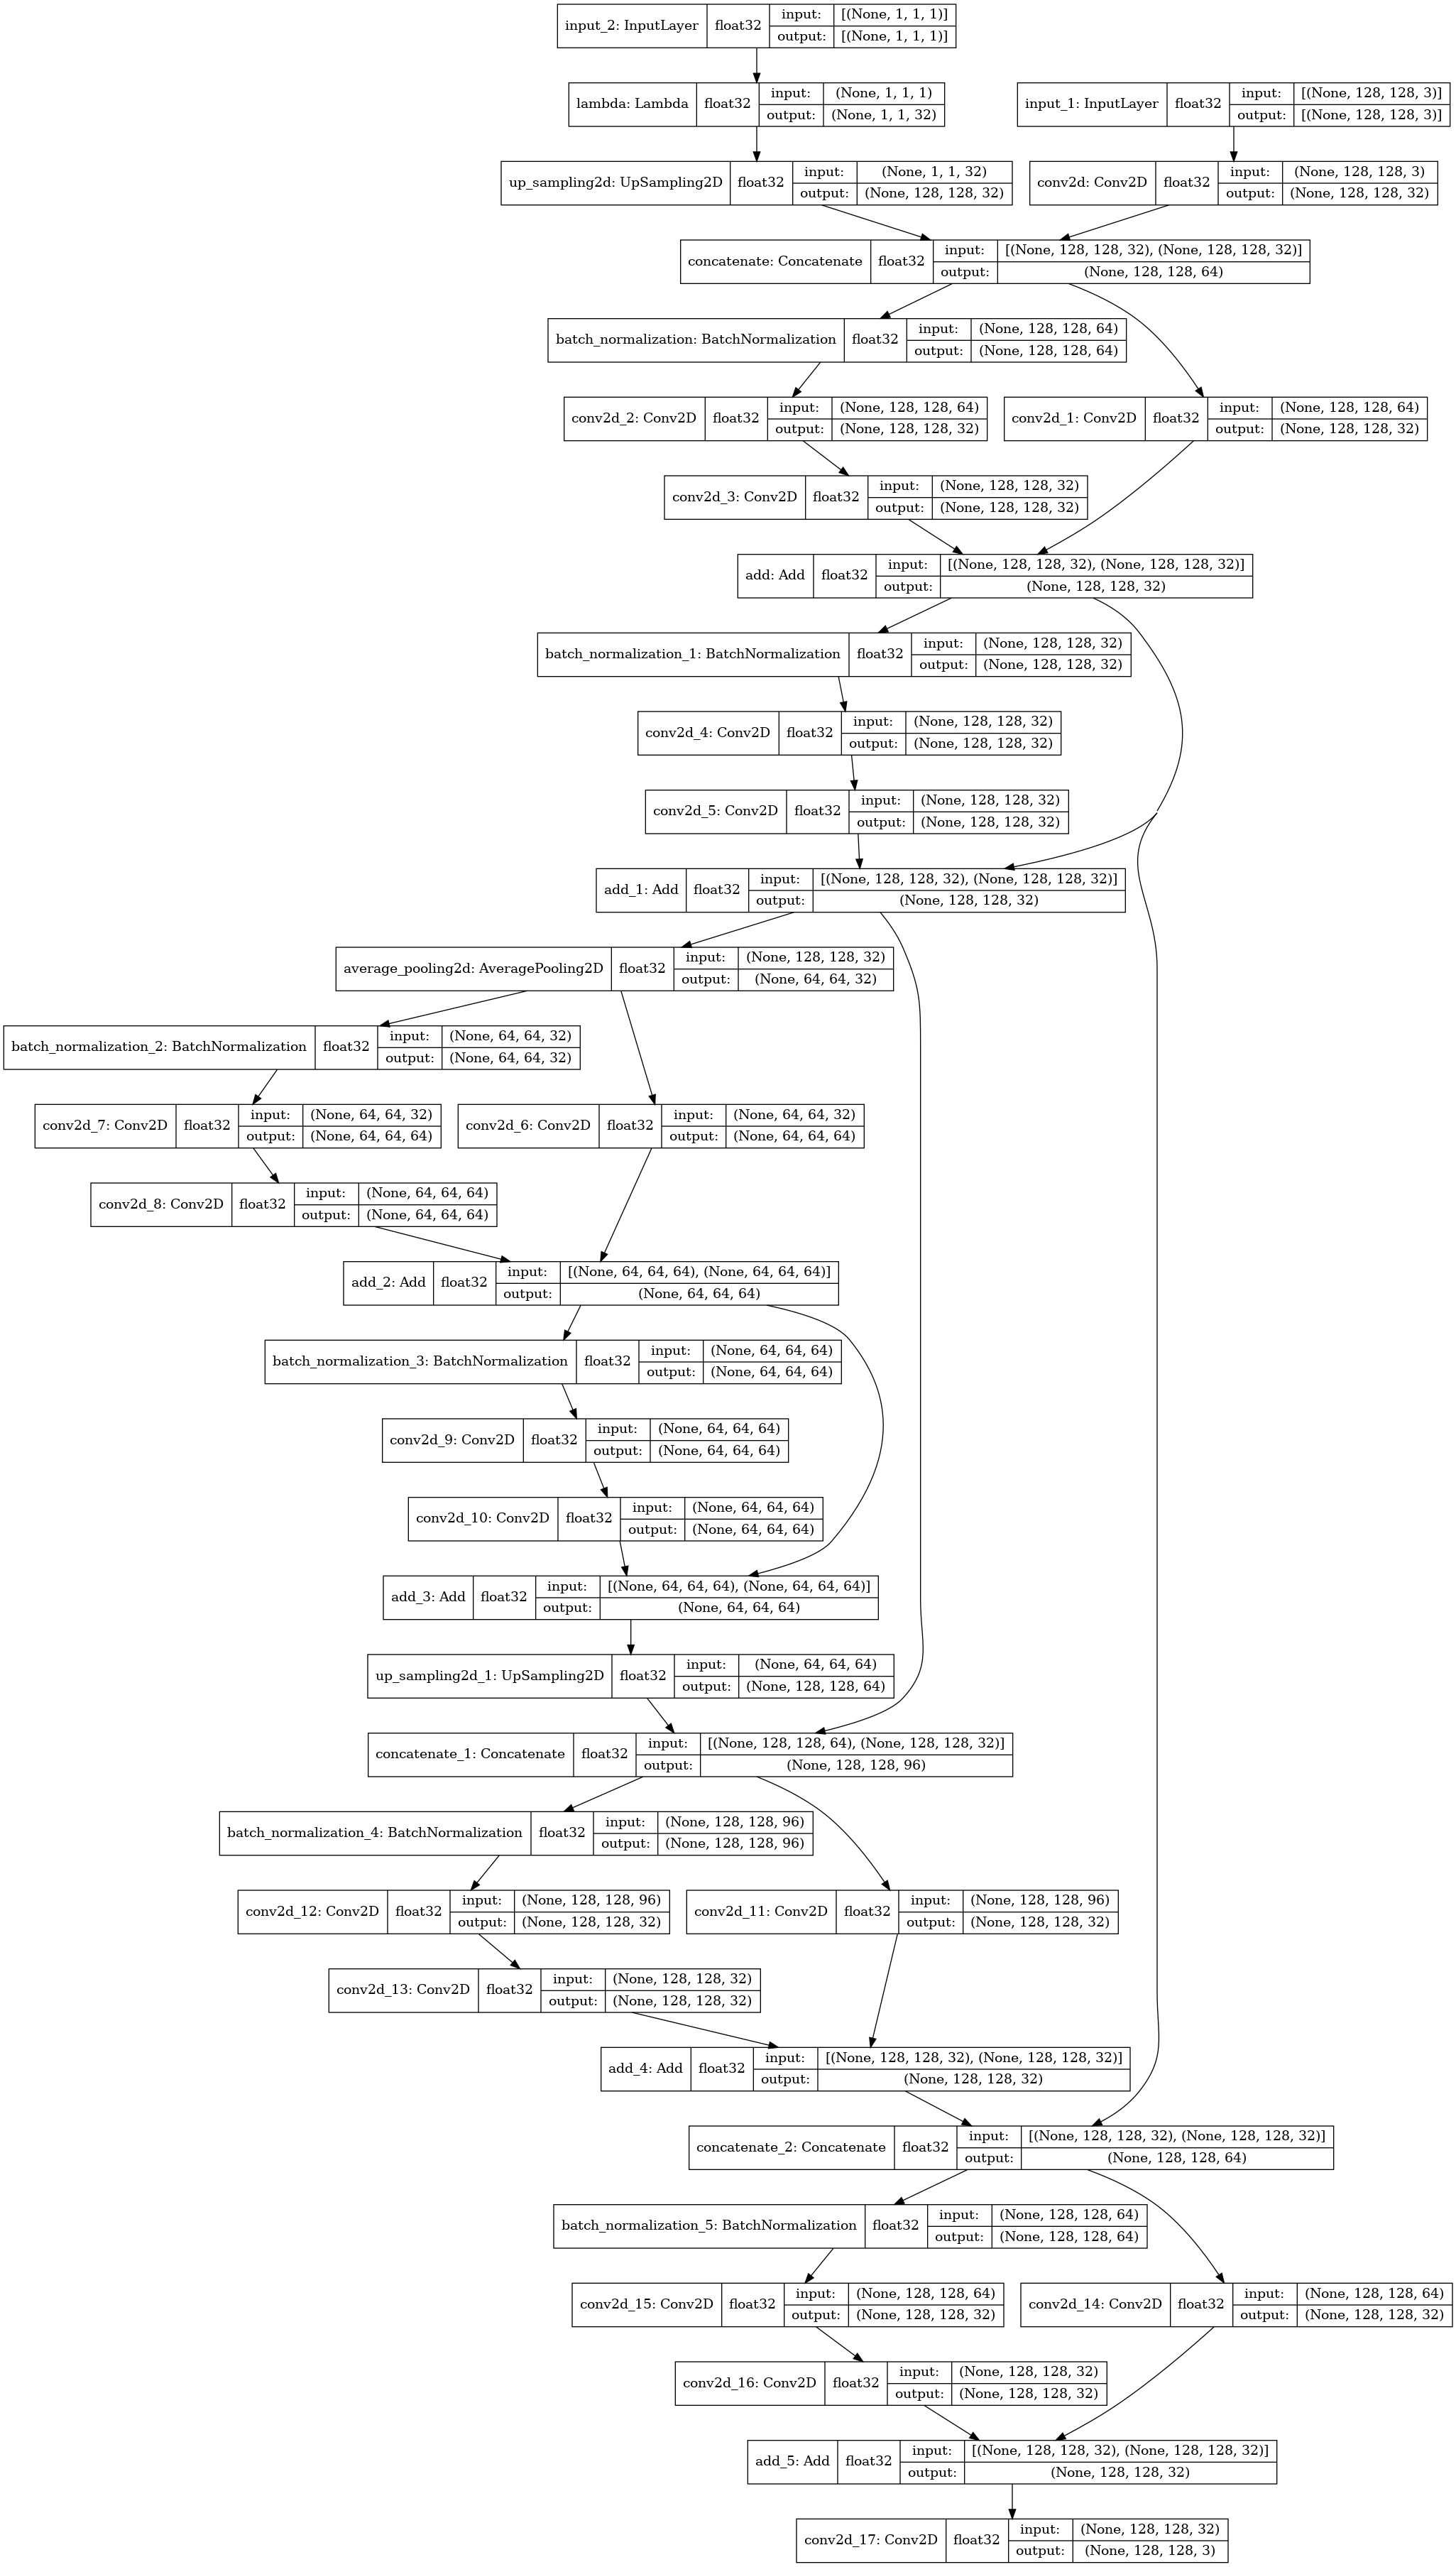

In [9]:
from tensorflow.keras.utils import plot_model

sample_network = get_network(128, [32,64], 2)

plot_model(sample_network, to_file = 'model.png', show_shapes = True, show_dtype = True, show_layer_names = True)


## Diffusion model

### Diffusion Schedule

* Diffusion process의 각 위치에서의 실제 diffusion time에 대응하는 noise level과 signal level를 말해주는 함수가 필요하다.
* 이것이 diffusion schedule 이다.
* Diffusion schedule은 2가지 값을 출력한다.
* noise_rate와 signal_rate(DDPM 논문에서 sqrt(1-alpha)와 sqrt(alpha)에 해당하는)
* 노이즈 이미지는 훈련 이미지에 정해진 비율에 따라 랜덤 노이즈를 부가하고 둘을 합치면서 생성한다.
* 랜덤 노이즈와 이미지가 모두 평균을 0으로 잡고 unit 분산을 가지기 때문에 노이즈 비율과 신호 비율은 노이즈 이미지에서 그들의 표준편차로 볼 수 있다.
* 그들 비율의 제곱은 결국 분산이 된다.
* 비율들은 제곱 합이 1이 되도록 설정되며, 이는 노이즈 이미지가 언제나 unit 분산을 가지는 것을 뜻합니다(변화되지않은 값들 처럼)
* 우린 cosine schedule의 simplifed, continuous 버전을 사용합니다.
* 이 스케쥴은 대칭적이며 Diffusion 시작과 끝을 향해선 느려지며, trigonometric properties of the unit circle을 통한 기하하적 해석을 가집니다.

### Training Process

* train 과정은 train_step과 denoise 이며
* 무작위 diffusion 시간을 균등하게 샘플하며
* 훈련 이미지와 무작위 가우시안 노이즈를 diffusion 시간에 따른 비율에 따라 섞습니다.
* 그리고 노이즈 이미지를 두 가지 요소로 나누기 위해 모델을 훈련합니다.
* 뉴런 네트워크는 변하지 않은 노이즈 요소를 예측하기 위해 학습되며 예측한 이미지 요소는 신호와 노이즈 비율에 따라 계산될 수 있습니다.
* 픽셀 단위의 MSE가 이론적으로 사용되나, 해당 dataset에서는 MAE가 더 좋게 나오니 이것을 사용하겠습니다.

### Sampling

* 샘플링에서는 (reverse diffusion()에서), 각 단계에서 노이즈 이미지의 이전 예측값을 우리의 네트워크를 사용해서 노이즈와 이미지로 나눕니다.
* 해당 단계에서의 신호와 노이즈 비율을 사용하여 다시 재결합합니다.
* Stochastic sampling 네트워크를 재훈련하지 않고도 사용할 수 있다(두 모델 다 같은 방식으로 훈련하기 때문)

In [ ]:
class DiffusionModel(keras.Model):
    def __init__(self, image_size, widths, block_depth):
        super().__init__()

        self.normalizer = layers.Normalization()
        self.network = get_network(image_size, widths, block_depth)
        self.ema_network = keras.models.clone_model(self.network)

    def compile(self, **kwargs):
        super().compile(**kwargs)

        self.noise_loss_tracker = keras.metrics.Mean(name="n_loss")
        self.image_loss_tracker = keras.metrics.Mean(name="i_loss")
        self.kid = KID(name="kid")

    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.image_loss_tracker, self.kid]

    def denormalize(self, images):
        # convert the pixel values back to 0-1 range
        images = self.normalizer.mean + images * self.normalizer.variance**0.5
        return tf.clip_by_value(images, 0.0, 1.0)

    def diffusion_schedule(self, diffusion_times):
        # diffusion times -> angles
        start_angle = tf.acos(max_signal_rate)
        end_angle = tf.acos(min_signal_rate)

        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

        # angles -> signal and noise rates
        signal_rates = tf.cos(diffusion_angles)
        noise_rates = tf.sin(diffusion_angles)
        # note that their squared sum is always: sin^2(x) + cos^2(x) = 1

        return noise_rates, signal_rates

    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        # the exponential moving average weights are used at evaluation
        if training:
            network = self.network
        else:
            network = self.ema_network

        # predict noise component and calculate the image component using it
        pred_noises = network([noisy_images, noise_rates**2], training=training)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        # reverse diffusion = sampling
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps

        # important line:
        # at the first sampling step, the "noisy image" is pure noise
        # but its signal rate is assumed to be nonzero (min_signal_rate)
        next_noisy_images = initial_noise
        for step in range(diffusion_steps):
            noisy_images = next_noisy_images

            # separate the current noisy image to its components
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=False
            )
            # network used in eval mode

            # remix the predicted components using the next signal and noise rates
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            next_noisy_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
            # this new noisy image will be used in the next step

        return pred_images

    def generate(self, num_images, diffusion_steps):
        # noise -> images -> denormalized images
        initial_noise = tf.random.normal(shape=(num_images, image_size, image_size, 3))
        generated_images = self.reverse_diffusion(initial_noise, diffusion_steps)
        generated_images = self.denormalize(generated_images)
        return generated_images

    def train_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=True)
        noises = tf.random.normal(shape=(batch_size, image_size, image_size, 3))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        with tf.GradientTape() as tape:
            # train the network to separate noisy images to their components
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=True
            )

            noise_loss = self.loss(noises, pred_noises)  # used for training
            image_loss = self.loss(images, pred_images)  # only used as metric

        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_weights))

        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)

        # track the exponential moving averages of weights
        for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
            ema_weight.assign(ema * ema_weight + (1 - ema) * weight)

        # KID is not measured during the training phase for computational efficiency
        return {m.name: m.result() for m in self.metrics[:-1]}

    def test_step(self, images):
        # normalize images to have standard deviation of 1, like the noises
        images = self.normalizer(images, training=False)
        noises = tf.random.normal(shape=(batch_size, image_size, image_size, 3))

        # sample uniform random diffusion times
        diffusion_times = tf.random.uniform(
            shape=(batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        # mix the images with noises accordingly
        noisy_images = signal_rates * images + noise_rates * noises

        # use the network to separate noisy images to their components
        pred_noises, pred_images = self.denoise(
            noisy_images, noise_rates, signal_rates, training=False
        )

        noise_loss = self.loss(noises, pred_noises)
        image_loss = self.loss(images, pred_images)

        self.image_loss_tracker.update_state(image_loss)
        self.noise_loss_tracker.update_state(noise_loss)

        # measure KID between real and generated images
        # this is computationally demanding, kid_diffusion_steps has to be small
        images = self.denormalize(images)
        generated_images = self.generate(
            num_images=batch_size, diffusion_steps=kid_diffusion_steps
        )
        self.kid.update_state(images, generated_images)

        return {m.name: m.result() for m in self.metrics}

    def plot_images(self, epoch=None, logs=None, num_rows=3, num_cols=6):
        # plot random generated images for visual evaluation of generation quality
        generated_images = self.generate(
            num_images=num_rows * num_cols,
            diffusion_steps=plot_diffusion_steps,
        )

        plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
        for row in range(num_rows):
            for col in range(num_cols):
                index = row * num_cols + col
                plt.subplot(num_rows, num_cols, index + 1)
                plt.imshow(generated_images[index])
                plt.axis("off")
        plt.tight_layout()
        plt.show()
        plt.close()

## 학습

In [ ]:
!pip install tensorflow_addons

In [ ]:
import tensorflow_addons as tfa

# create and compile the model
model = DiffusionModel(image_size, widths, block_depth)
# below tensorflow 2.9:
# pip install tensorflow_addons
# import tensorflow_addons as tfa
# optimizer=tfa.optimizers.AdamW
model.compile(
#   optimizer=keras.optimizers.experimental.AdamW(
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    loss=keras.losses.mean_absolute_error,
)
# pixelwise mean absolute error is used as loss

# save the best model based on the validation KID metric
# checkpoint_path = "checkpoints/diffusion_model"
checkpoint_path = "/aiffel/aiffel/AIFFELTHON/checkpoint/diffusion_model"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor="val_kid",
    mode="min",
    save_best_only=True,
)

# calculate mean and variance of training dataset for normalization
model.normalizer.adapt(train_dataset)

# run training and plot generated images periodically
model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=val_dataset,
    callbacks=[
        keras.callbacks.LambdaCallback(on_epoch_end=model.plot_images),
        checkpoint_callback,
    ],
)

## 인퍼런스

In [ ]:
# load the best model and generate images
model.load_weights(checkpoint_path)
model.plot_images()